In [1]:
%matplotlib inline

import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.linear_model import *
from sklearn.cross_validation import KFold

from sklearn.metrics import mean_squared_error, r2_score

from math import sqrt

STORYLINES_LOC = '../data/movie_storylines.bigdata'

In [2]:
# read in storylines, ignore movies with no storyline
storylines = {}
with open(STORYLINES_LOC) as f:
    for line in f:
        data = line.rstrip().split('|')
        if data[1] != '':
            if data[0] not in storylines:
                storylines[data[0]] = data[1]

In [3]:
import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords

chars = ['{','}','#','%','&','\(','\)','\[','\]','<','>',',', '!', '.', ';',
'?', '*', '\\', '\/', '~', '_','|','=','+','^',':','\"','\'','@','-']

In [4]:
# get movie name associated with each ID
from json import loads
MOVIE_DATA_LOC = '../data/movies.bigdata'

# read in movie data
movie_data = []
with open(MOVIE_DATA_LOC) as f:
    for line in f:
        movie_data.append(loads(line))
        
# mapping of movie_id to name
movie_name_mapping = {}
movie_year_mapping = {}
movie_rating_mapping = {}

for entry in movie_data:
    movie_ID = entry['data']['tconst']
    if movie_ID not in movie_name_mapping:
        movie_name_mapping[movie_ID] = entry['data']['title']
        try:
            movie_year_mapping[movie_ID] = int(entry['data']['year'])
        except ValueError:
            movie_year_mapping[movie_ID] = -1
        try:
            movie_rating_mapping[movie_ID] = float(entry['data']['rating'])
        except KeyError:
            movie_rating_mapping[movie_ID] = -1.

In [5]:
MIN_NUM_TOKENS = 5

# from Assignment 1 code
porter = nltk.PorterStemmer() # also lancaster stemmer
wnl = nltk.WordNetLemmatizer()
stopWords = stopwords.words("english")
words = {}
movie_tokens = {}
movie_index_mapping = {}
index_movie_mapping = {}

# get words and counts
movie_last_index = 0
for movie_ID, storyline in storylines.iteritems():
    storyline = storyline.decode('latin1')
    # remove noisy characters; tokenize
    raw = re.sub('[%s]' % ''.join(chars), ' ', storyline)
    tokens = word_tokenize(raw)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    tokens = [w for w in tokens if w not in stopWords]
    tokens = [wnl.lemmatize(t) for t in tokens]
    tokens = [porter.stem(t) for t in tokens]
    
    # only want some tokens
    if len(tokens) >= MIN_NUM_TOKENS:
        if movie_ID not in movie_index_mapping:
            if movie_ID in movie_year_mapping:
                if movie_rating_mapping[movie_ID] != -1:
                    if 0 <= movie_year_mapping[movie_ID]:
                        for t in tokens:
                            # this is a hack but much faster than lookup each
                            # word within many dict keys
                            try:
                                words[t] = words[t]+1
                            except:
                                words[t] = 1
                        movie_tokens[movie_ID] = tokens
                        movie_index_mapping[movie_ID] = movie_last_index
                        index_movie_mapping[movie_last_index] = movie_ID
                        movie_last_index += 1

In [6]:
MIN_OCCURS = 5

# remove all ones that have less than MIN_OCCURS occurrences
# assign indices
word_last_index = 0
word_index_mapping = {}
index_word_mapping = {}
for word, count in words.iteritems():
    if count >= MIN_OCCURS:
        word_index_mapping[word] = word_last_index
        index_word_mapping[word_last_index] = word
        word_last_index += 1

In [7]:
# from the scipy.sparse library, do the importation of the csc_matrix
from scipy.sparse import csc_matrix

# prepare binary feature matrix, rows = movies, columns = actors
matrix = np.zeros(shape=(len(movie_index_mapping), len(word_index_mapping)), dtype=np.uint8)

ratings = np.empty(shape=len(movie_index_mapping), dtype=float)

for movie_ID, movie_index in movie_index_mapping.iteritems():
    for word in movie_tokens[movie_ID]:
        if word in word_index_mapping:
            word_index = word_index_mapping[word]
            matrix[movie_index, word_index] += 1
    ratings[movie_index] = movie_rating_mapping[movie_ID]
            
smatrix = csc_matrix(matrix)

In [8]:
def rmse(test_classes_true, test_classes_pred):
    return sqrt(mean_squared_error(test_classes_true, test_classes_pred))

def predict(train_feature_matrix, train_classes, test_feature_matrix, test_classes_real, classifier):
    classifier.fit(train_feature_matrix, train_classes)
    test_classes_pred = classifier.predict(test_feature_matrix)
    return test_classes_pred, test_classes_real

# cross validation predict
def cv_predict(feature_matrix, classes, classifier, k):
    kf = KFold(len(classes), n_folds=k)
    results = []
    for train, test in kf:
        train_feature_matrix = feature_matrix[train]
        train_classes = classes[train]
        test_feature_matrix = feature_matrix[test]
        test_classes_real = classes[test]
        results.append(predict(train_feature_matrix, train_classes, test_feature_matrix, test_classes_real, classifier))
    return results

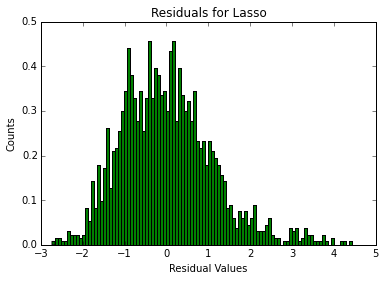

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute='auto', tol=0.0001,
   warm_start=False)
1.08700419117 0.0432536409906 3.46700000763


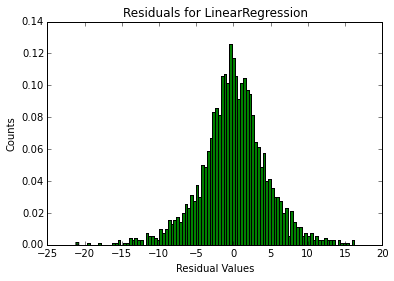

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
4.45868867078 -15.1669292709 23.143999815


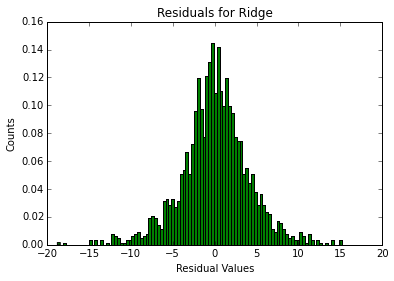

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)
4.04457321038 -12.2944339376 9.28100013733


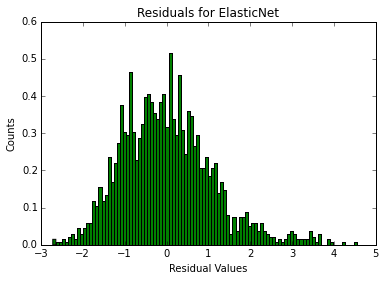

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute='auto',
      tol=0.0001, warm_start=False)
1.07318991382 0.0674724560964 3.80500006676


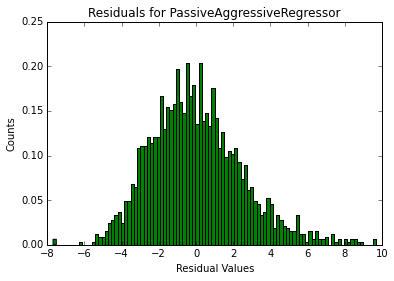

PassiveAggressiveRegressor(C=1.0, class_weight=None, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive', n_iter=5,
              random_state=None, shuffle=False, verbose=0,
              warm_start=False)
2.45522538676 -3.88582869833 0.885999917984


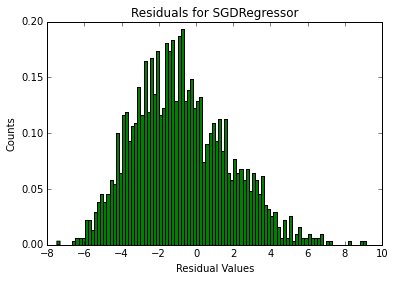

SGDRegressor(alpha=0.01, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='invscaling', loss='squared_loss',
       n_iter=5, penalty='l2', power_t=0.25, random_state=None,
       shuffle=False, verbose=0, warm_start=False)
2.66442287475 -4.74904796217 0.826999902725


In [9]:
regressors = [
    Lasso(alpha=0.01),
    LinearRegression(),
    Ridge(alpha=0.01),
    ElasticNet(alpha=0.01),
    PassiveAggressiveRegressor(),
    SGDRegressor(alpha=0.01)
]

K = 5

for regressor in regressors:
    total_rmse = 0
    total_r2_score = 0
    start_time = time()

    for i, (pred_values, true_values) in enumerate(cv_predict(smatrix, ratings, regressor, K)):
        total_rmse += rmse(true_values, pred_values)
        total_r2_score += r2_score(true_values, pred_values)
        
        # plot residuals for first set of folds
        if i == 0:
            residuals = []
            for pred, real in zip(pred_values, true_values):
                residuals.append(pred - real)
            plt.figure(i)
            plt.hist(residuals, bins=100, normed=1, facecolor='green')
            plt.xlabel('Residual Values')
            plt.ylabel('Counts')
            plt.title('Residuals for %s' % regressor.__class__.__name__)
            plt.savefig("residuals_%s_%s.png" % ('bag_of_words', regressor.__class__.__name__), dpi=300)
            plt.show()

    avg_rmse = total_rmse / K
    avg_r2_score = total_r2_score / K
    
    # bring basic info
    print regressor
    print avg_rmse, avg_r2_score, time() - start_time